### Describe and Format Data for Modeling

- Joel Stremmel
- 04-17-23

##### About

Format the transcript data and survery responses to train binary classifiers with K-Fold cross-validation.

##### Imports

In [1]:
import os
import re
import glob
import torch
import pickle
import statistics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pdfminer.high_level import extract_text
from transformers import AutoTokenizer, pipeline

##### Set Parameters

In [2]:
# Set sequence lengths for distribution plot and sentiment model
dist_max_seq_len = 32768

# Set model/tokenizer paths
dist_tokenizer_path = "allenai/longformer-base-4096"

# Define data directory
pdf_dir = './data/session_transcripts_iteration_2'

# Define survey data path
survey_path = './data/WDS_Session_Survey_April_13_2023_17.07_ONLY Iteration2.xlsx'

# Define total number of sessions
num_sessions = 10

# Define the number of folds for K-Fold CV as a fraction  of the number of sessions
# Set to -1 for the number of folds to be equal to the number of sessions
# Otherwise, the number of folds is equal to the number of sessions divided by this value
div_num_folds = 2

# Group leaders
leaders = [
    'Hannah Norling (she/her)',
    'Devin Kelly (she/her/hers)',
    'Lisa Brownstone (She/Her)'
]

# Define session participants
participants = {
    'Betty_2': 8,
    'Martha_2': 9,
    'Tanya_2': 16,
    'Bonnie_2': 14,
    'Sharon_2': 10,
    'Cecilia_2': 11,
    'Maya_2': 17,
    'Addison_2': 12,
    'Penny_2': 15,
    'Gemma_2': 13
}

# Define speakers as the combined set of leaders and participants
speakers = leaders + list(participants.keys())

# Set the default color cycle
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                  '#000000', '#8DA0CB', '#A6D854',
                  '#E5C494']
assert len(CB_color_cycle) == len(speakers), "Number of colors should equal number of speakers."
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=CB_color_cycle) 

# Define separator token for utterances
sep_token = "</s>"

# Outcome variable
outcome = 'GEM' # 'GSRS_Tot' # 'GEM'

# Define outcome cutoff
outcome_cutoff = 4 # 9 # 4

##### Load Tokenizer

In [3]:
dist_tokenizer = AutoTokenizer.from_pretrained(dist_tokenizer_path)

##### Load Survey Data

In [4]:
df = pd.read_excel(survey_path)
df.shape

(73, 16)

##### Define Score and Text Dataframes from Surveys

In [5]:
score_df = df[[
    'Session',
    'ID',
    outcome,
]]
score_df.shape

(73, 3)

##### View Outcome Distribution for Participants

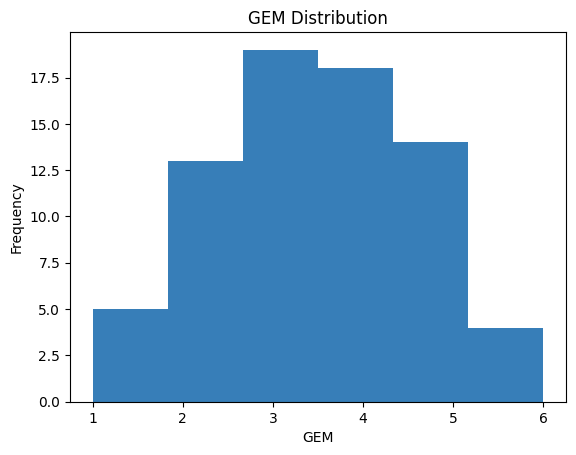

In [6]:
plt.hist(score_df[outcome], bins=6)
plt.xlabel(outcome)
plt.ylabel('Frequency')
plt.title(f'{outcome} Distribution')
plt.show()

##### View Binarized Outcome Distribution for Participants

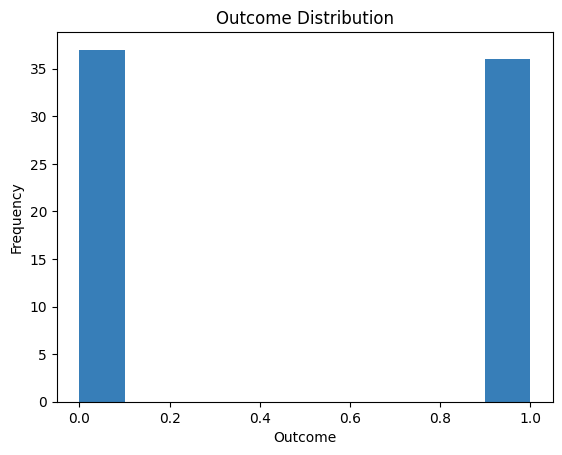

Above cutoff: 37.
Below cutoff: 36.


In [7]:
plt.hist([1 if x >= outcome_cutoff else 0 for x in score_df[outcome].tolist()])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Outcome Distribution')
plt.show()

print(f"Above cutoff: {score_df[score_df[outcome] < outcome_cutoff].shape[0]}.")
print(f"Below cutoff: {score_df[score_df[outcome] >= outcome_cutoff].shape[0]}.")

##### Plot Scores per Participant per Session

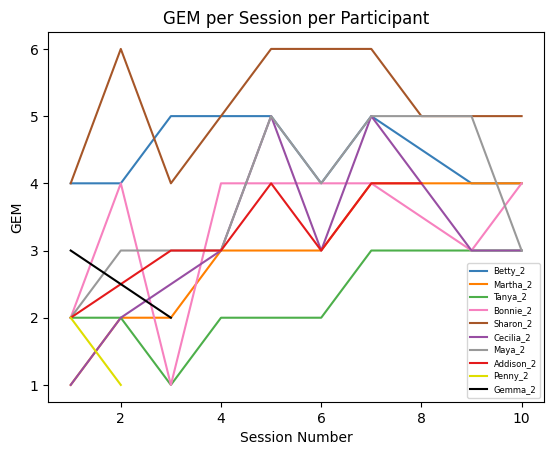

In [8]:
fig, ax = plt.subplots()
for participant, participant_id in participants.items():
    
    x = score_df[score_df['ID'] == participant_id]['Session'].tolist()
    y = score_df[score_df['ID'] == participant_id][outcome].tolist()
    ax.plot(x, y, label=participant)

    # Set plot title and axis labels
    ax.set_title(f'{outcome} per Session per Participant')
    ax.set_xlabel('Session Number')
    ax.set_ylabel(f'{outcome}')

    # Set legend
    ax.legend(fontsize=6, loc='best')

# Show plot
plt.show()

##### Collect PDFs of Transcripts

In [9]:
pdf_files = glob.glob(os.path.join(pdf_dir, '*.pdf'))

##### Define Function to Remove Lines

In [10]:
def should_remove(line):
    line = line.strip()
    if line.isdigit() or not line or (line.startswith('{') and line.endswith('}')):
        return True

##### Extract Text and Count Words per Speaker

In [11]:
# Save complete utterances
speaker_utterances = {speaker: {num: [] for num in range(len(pdf_files))} for speaker in speakers}

# Iterate through files to extract words
for i, file in enumerate(pdf_files):
    
    # Reset current speaker
    current_speaker = None
    
    # Reset utterance
    utterance = ""
    
    # Extract text
    text = extract_text(file)
    
    # Iterate through text split on double new lines
    for line in text.split('\n'):
        
        # If the line is blank, keep going
        if not line:
            continue

        # Check if one of the speakers is speaking
        for speaker in speakers:
            if line.startswith(speaker + ':'):
                
                # If the current speaker is the same as this speaker, keep going
                if current_speaker == speaker:
                    break
                
                # Otherwise, we have a new speaker and we want to save the full utterance
                # from the previous speaker, set the new speaker, and reset the utterance
                # If the current speaker is None, it's our first iteration and there's
                # Nothing to save
                else:
                    if current_speaker is None:
                        assert utterance == "", "Expected utterance to be empty."
                    else:
                        speaker_utterances[current_speaker][i].append(utterance)
                    current_speaker = speaker
                    utterance = ""

        # If we have a current speaker, add the utterance
        if current_speaker:
            
            # Handle empty lines, bracketted info, and page numbers
            if should_remove(line):
                continue
            
            # Remove the speaker name from the line
            # Split on any number of whitespaces to define the words in the line
            clean_line = line.replace(current_speaker + ':', '')
                
            # Add to the utterance which will contain words seperated only by single spaces
            utterance += " ".join(clean_line.split())

##### Define Function to Differentiate between Participants and Leaders

In [12]:
def add_leader_tag(d, leaders):
    
    d_plot = {}
    for k, v in d.items():
        if k in leaders:
            d_plot[k + ' - Leader'] = v
        else:
            d_plot[k] = v
            
    return d_plot

##### Plot the Number of Utterances from Each Speaker for Each Session

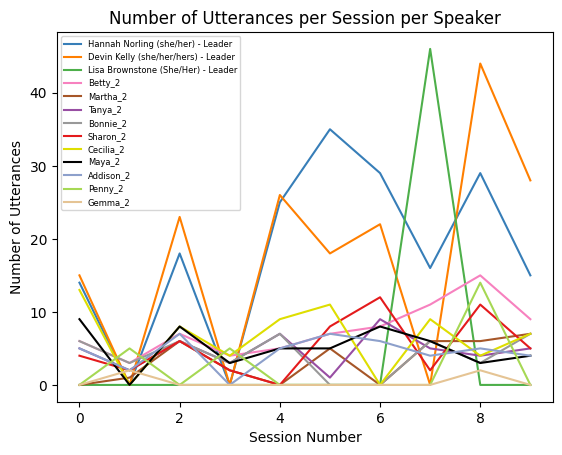

In [13]:
# Create plot
fig, ax = plt.subplots()
for key in speaker_utterances:
    x = list(speaker_utterances[key].keys())
    y = [len(speaker_utterances[key][i]) for i in x]
    
    if key in leaders:
        label = key + ' - Leader'
    else:
        label = key
        
    ax.plot(x, y, label=label)

# Set plot title and axis labels
ax.set_title('Number of Utterances per Session per Speaker')
ax.set_xlabel('Session Number')
ax.set_ylabel('Number of Utterances')

# Set legend
ax.legend(fontsize=6, loc='best')

# Show plot
plt.show()

##### Filter to Participants

In [14]:
participant_utterances = {k: v for k, v in speaker_utterances.items() if k not in leaders}

##### Plot the Number of Tokens for all Utterances from Each Participant for Each Session and Save Utterance Text and Scores

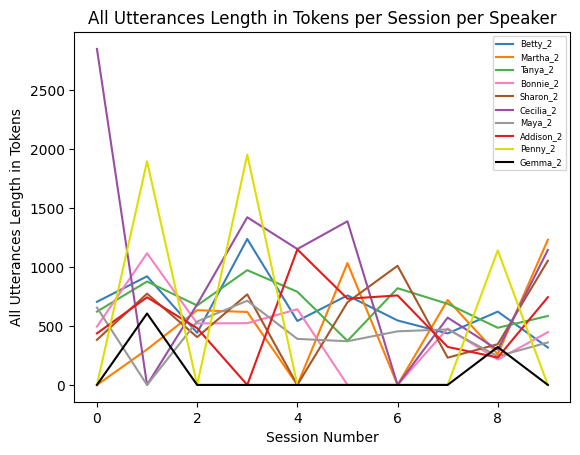

In [15]:
# Create lists to save utterance text, participant scores, and participant names and IDs
X_fold_text = []
y_fold_score = []
participant_fold_names_ids = []

# Generate plots and the data to fill the lists above by iterating through all participant utterances
fig, ax = plt.subplots()
for key in participant_utterances:
    
    # We'll use these for the plot
    x = list(participant_utterances[key].keys())
    y = []
    
    # Fill the empty lists above with info for this participant from each session 
    for i in x:
        
        # Build list of all utterances for this participant
        all_utterances = participant_utterances[key][i]
        
        # Add the sep token to the utterance text to separate utterances and combine them into one string
        all_utterance_text = sep_token.join(all_utterances)
        
        # Get the outcome score for the given session and participant
        # Note that the session numbers start at 1 in score_df
        s_num = i + 1
        score_row = score_df[(score_df['Session'] == s_num) & (score_df['ID'] == participants[key])][outcome]
        
        # Check that either the score is missing and the row is empty or there is one value for the score
        assert score_row.shape[0] in [0, 1], f"Unexpected score row shape {score_row.shape}"
        
        # If a non-missing score is recorded, save it along with the utterance text and participant name and ID
        if score_row.shape[0] == 1 and not score_row.isnull().values.any():
            
            X_fold_text.append(all_utterance_text)
            y_fold_score.append(score_row.item())
            participant_fold_names_ids.append((i, key, participants[key]))
        
        # Compute the number of subwords in the utterance text 
        tokenized_text = dist_tokenizer(
            all_utterance_text,
            padding=False,
            truncation=True,
            max_length=dist_max_seq_len
        )
        num_subwords = len(tokenized_text['input_ids'])
        y.append(num_subwords)
    
    if key in leaders:
        label = key + ' - Leader'
    else:
        label = key
        
    ax.plot(x, y, label=label)

# Set plot title and axis labels
ax.set_title('All Utterances Length in Tokens per Session per Speaker')
ax.set_xlabel('Session Number')
ax.set_ylabel('All Utterances Length in Tokens')

# Set legend
ax.legend(fontsize=6, loc='best')

# Show plot
plt.show()

##### Turn Saved Utterance Text and Scores into Data Folds and Threshold Scores
This assumes the data will be used to train binary classifiers with K-Fold cross-validation where K is equal to the number of sessions and the the binary outcome variable is defined according to `outcome_cutoff`.

In [16]:
X_folds = {i: [] for i in range(num_sessions)}
y_folds = {i: [] for i in range(num_sessions)}
names_ids = {i: [] for i in range(num_sessions)}

for record, text, score in zip(participant_fold_names_ids, X_fold_text, y_fold_score):
    
    session_number = record[0]
    name = record[1]
    participant_id = record[2]
    
    binary_score = 1 if score >= outcome_cutoff else 0
    
    X_folds[session_number].append(text)
    y_folds[session_number].append(binary_score)
    names_ids[session_number].append((name, participant_id))

##### Optionally Combine Folds 
If desired, K can be less than the number of sessions. Use `div_num_folds` to reduce the number of folds to `num_sessions` / `div_num_folds`.

In [17]:
if div_num_folds > 0:
    X_folds = {fold: X_folds[i] + X_folds[i + 1] for fold, i in enumerate(range(0, num_sessions, div_num_folds))}
    y_folds = {fold: y_folds[i] + y_folds[i + 1] for fold, i in enumerate(range(0, num_sessions, div_num_folds))}
    names_ids = {fold: names_ids[i] + names_ids[i + 1] for fold, i in enumerate(range(0, num_sessions, div_num_folds))}

##### Pickle the Data to Use for Modeling

In [18]:
with open('data/X_folds.pkl', 'wb') as f:
    pickle.dump(X_folds, f)

with open('data/y_folds.pkl', 'wb') as f:
    pickle.dump(y_folds, f)
    
with open('data/names_ids.pkl', 'wb') as f:
    pickle.dump(names_ids, f)